In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Functional_Fusion.reliability as rel
from collections import Counter
import os
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.cio as cio

In [2]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
train_ses = ['all', 'ses-localizer_cond', 'all', 'all', 'all', 'all', 'all']
logalpha_list = [6, 6, 6, 2, 2, 8, 6]

# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/bestSTD_product_matrix.npz", allow_pickle=True)
indices = []
for ds, la in zip(dataset_list, logalpha_list):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
product_la = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec_la = data['dataset_vec'][indices]
sub_vec_la = data['sub_vec'][indices]
part_vec_la = data['part_vec'][indices]

# Solve
full_var_decom_df = rel.decompose_variance_scaled_from_SS(product_la, dataset_vec_la, sub_vec_la, part_vec_la)

Bad pairs (cross-dataset): 8.74%
Bad pairs (cross-subject): 1.49%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%


In [3]:
subject_counts = full_var_decom_df.groupby('train_dataset')['subj_id'].count()
subject_counts = subject_counts.reindex(dataset_list, fill_value=0)
print(subject_counts)
print(f'Total number of subjects: {subject_counts.sum()}')

train_dataset
MDTB           24
Language       17
WMFS           16
Demand         37
Somatotopic     8
Nishimoto       6
IBC            12
Name: subj_id, dtype: int64
Total number of subjects: 120


In [4]:
# Load avg connectivity models to calculate their norm
coef_norms = []
for i, (la, tdata, tses) in enumerate(zip(logalpha_list, dataset_list, train_ses)):
    print(f'Loading avg model for {tdata} - {tses}')
    mname = f"{tdata}_{tses}_Icosahedron1002_L2reghalf"
    model_path = os.path.join(gl.conn_dir,'MNISymC3','train',mname)
    m = mname + f"_A{la}_avg"
    fname = model_path + f"/{m}"
    conn_mo, info = cio.load_model(fname)
    coef_norms.append(np.linalg.norm(conn_mo.coef_))

Loading avg model for MDTB - all
Loading avg model for Language - ses-localizer_cond
Loading avg model for WMFS - all
Loading avg model for Demand - all
Loading avg model for Somatotopic - all
Loading avg model for Nishimoto - all
Loading avg model for IBC - all


In [6]:
eff_weights = pd.DataFrame(index=full_var_decom_df.train_dataset, columns=['avg', 'bayes'])
eff_weights['avg'] = np.array([1 / subject_counts[ds] for ds in subject_counts.index for _ in range(subject_counts[ds])])
eff_weights['avg'] /= np.array([coef_norms[dataset_list.index(ds)] * len(dataset_list) for ds in eff_weights.index])
eff_weights['avg'] = eff_weights['avg'] / eff_weights['avg'].sum()

eff_weights['bayes'] = np.array([1 / (row.sc * (row.v_d + row.v_s + row.v_m/2)) for _, row in full_var_decom_df.iterrows()])
eff_weights['bayes'] /= eff_weights['bayes'].sum()

In [7]:
print(round(eff_weights['avg'].sum(), 1))
print(round(eff_weights['bayes'].sum(), 1))

1.0
1.0


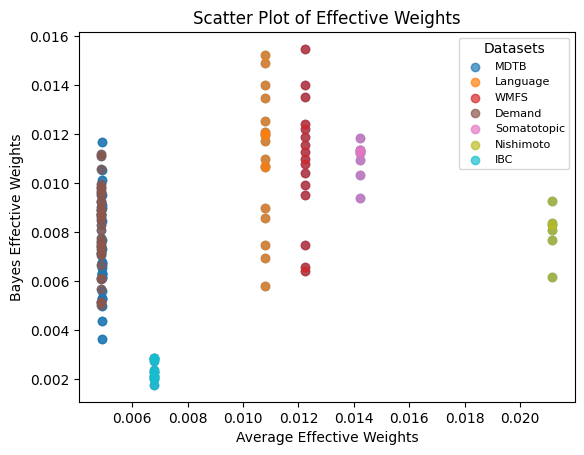

In [8]:
plt.scatter(eff_weights['avg'], eff_weights['bayes'], alpha=0.7)
plt.xlabel('Average Effective Weights')
plt.ylabel('Bayes Effective Weights')
plt.title('Scatter Plot of Effective Weights')

# Assign a unique color to each dataset using the 'tab10' colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(dataset_list)))

# Scatter plot with colors for each dataset
for i, dataset in enumerate(dataset_list):
    dataset_points = eff_weights.loc[dataset]
    plt.scatter(dataset_points['avg'], dataset_points['bayes'], label=dataset, color=colors[i], alpha=0.7)

# Add legend
plt.legend(title="Datasets", fontsize=8)

Sum of Average Model Effective Weights: 1.0
Sum of Bayes Model Effective Weights: 1.0


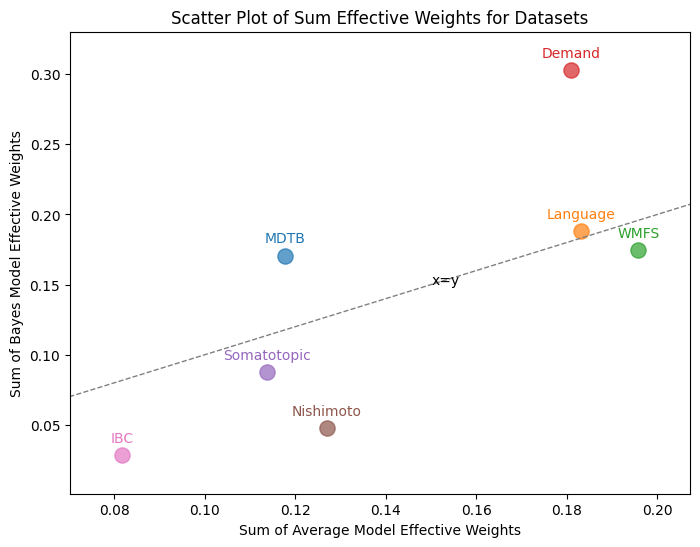

In [9]:
dataset_eff_weights = eff_weights.groupby(eff_weights.index).sum().reindex(dataset_list)

# plot the scatter plot
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors[:len(dataset_list)]  # Use the dark version of tab10
sum_a = 0
sum_b = 0
for i, dataset in enumerate(dataset_list):
    a = dataset_eff_weights[dataset_eff_weights.index == dataset]['avg'].values[0]
    b = dataset_eff_weights[dataset_eff_weights.index == dataset]['bayes'].values[0]
    plt.scatter(a, b, color=colors[i], alpha=0.7, s=120)
    plt.text(a, b + 0.007, dataset, fontsize=10, ha='center', va='bottom', color=colors[i])
    sum_a += a
    sum_b += b

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
plt.annotate('x=y', xy=(0.15, 0.15), fontsize=10, color='black')
y_range = max(dataset_eff_weights['bayes']) - min(dataset_eff_weights['bayes'])
x_range = max(dataset_eff_weights['avg']) - min(dataset_eff_weights['avg'])
plt.xlim(min(dataset_eff_weights['avg'])-x_range*0.1, max(dataset_eff_weights['avg'])+x_range*0.1)
plt.ylim(min(dataset_eff_weights['bayes'])-y_range*0.1, max(dataset_eff_weights['bayes'])+y_range*0.1)
plt.xlabel('Sum of Average Model Effective Weights')
plt.ylabel('Sum of Bayes Model Effective Weights')
plt.title('Scatter Plot of Sum Effective Weights for Datasets')

print(f"Sum of Average Model Effective Weights: {sum_a}")
print(f"Sum of Bayes Model Effective Weights: {sum_b}")

In [10]:
eff_weights['level_bayes'] = np.array([1 / (row.sc * (row.v_s + row.v_m/2)) for _, row in full_var_decom_df.iterrows()])
eff_weights['level_bayes'] *= np.array([1 / (row.v_d) for _, row in full_var_decom_df.iterrows()])
eff_weights['level_bayes'] /= eff_weights['level_bayes'].sum()

Sum of Average Model Effective Weights: 1.0
Sum of Bayes Model Effective Weights: 1.0


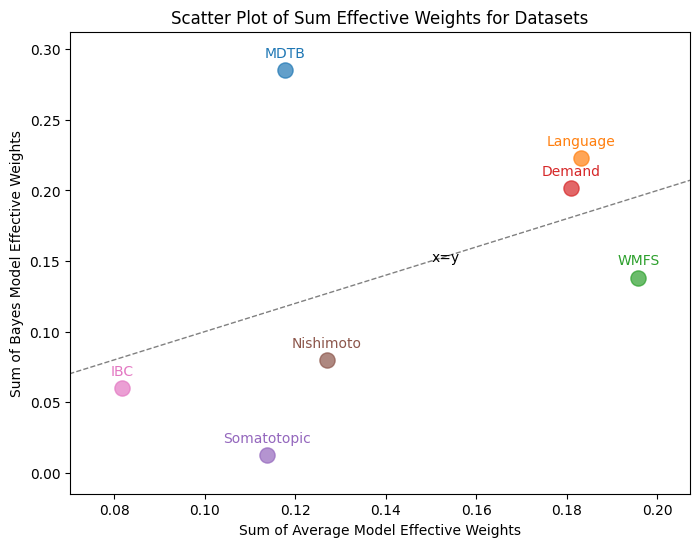

In [11]:
dataset_eff_weights = eff_weights.groupby(eff_weights.index).sum().reindex(dataset_list)

# plot the scatter plot
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors[:len(dataset_list)]  # Use the dark version of tab10
sum_a = 0
sum_b = 0
for i, dataset in enumerate(dataset_list):
    a = dataset_eff_weights[dataset_eff_weights.index == dataset]['avg'].values[0]
    b = dataset_eff_weights[dataset_eff_weights.index == dataset]['level_bayes'].values[0]
    plt.scatter(a, b, color=colors[i], alpha=0.7, s=120)
    plt.text(a, b + 0.007, dataset, fontsize=10, ha='center', va='bottom', color=colors[i])
    sum_a += a
    sum_b += b

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
plt.annotate('x=y', xy=(0.15, 0.15), fontsize=10, color='black')
y_range = max(dataset_eff_weights['level_bayes']) - min(dataset_eff_weights['level_bayes'])
x_range = max(dataset_eff_weights['avg']) - min(dataset_eff_weights['avg'])
plt.xlim(min(dataset_eff_weights['avg'])-x_range*0.1, max(dataset_eff_weights['avg'])+x_range*0.1)
plt.ylim(min(dataset_eff_weights['level_bayes'])-y_range*0.1, max(dataset_eff_weights['level_bayes'])+y_range*0.1)
plt.xlabel('Sum of Average Model Effective Weights')
plt.ylabel('Sum of Bayes Model Effective Weights')
plt.title('Scatter Plot of Sum Effective Weights for Datasets')

print(f"Sum of Average Model Effective Weights: {sum_a}")
print(f"Sum of Bayes Model Effective Weights: {sum_b}")